In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 103.5 MB/s eta 0:00:00


In [34]:
import os
import glob
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix ,jaccard_score
import seaborn as sns
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from skimage.transform import resize as sk_resize
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
import glob, rasterio
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from skimage.transform import resize as sk_resize
from tensorflow.keras import layers, Model
from tensorflow.keras import layers, models



In [35]:
zip_path = "data.zip"
extract_path = "data_extracted"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [36]:
image_dir = os.path.join(extract_path, "data/images")
label_dir = os.path.join(extract_path, "data/labels")
print(os.listdir(extract_path))
print(os.listdir(image_dir))
print(os.listdir(label_dir))

['data']
['87.tif', '199.tif', '162.tif', '193.tif', '75.tif', '172.tif', '13.tif', '268.tif', '47.tif', '155.tif', '102.tif', '191.tif', '251.tif', '67.tif', '17.tif', '242.tif', '256.tif', '209.tif', '22.tif', '60.tif', '293.tif', '296.tif', '19.tif', '281.tif', '214.tif', '77.tif', '34.tif', '4.tif', '236.tif', '271.tif', '235.tif', '156.tif', '40.tif', '275.tif', '64.tif', '273.tif', '128.tif', '129.tif', '224.tif', '63.tif', '98.tif', '194.tif', '173.tif', '24.tif', '105.tif', '228.tif', '35.tif', '134.tif', '78.tif', '154.tif', '133.tif', '269.tif', '279.tif', '225.tif', '143.tif', '91.tif', '42.tif', '117.tif', '302.tif', '289.tif', '74.tif', '116.tif', '11.tif', '226.tif', '189.tif', '220.tif', '104.tif', '125.tif', '110.tif', '223.tif', '68.tif', '175.tif', '27.tif', '270.tif', '153.tif', '249.tif', '16.tif', '26.tif', '112.tif', '161.tif', '121.tif', '69.tif', '206.tif', '208.tif', '3.tif', '101.tif', '86.tif', '48.tif', '217.tif', '280.tif', '100.tif', '177.tif', '211.tif', 

In [38]:
label_dir = os.path.join(extract_path, "data/labels")

for filename in os.listdir(label_dir):
    new_name = filename.replace("_", "")
    old_path = os.path.join(label_dir, filename)
    new_path = os.path.join(label_dir, new_name)
    os.rename(old_path, new_path)

print("Renamed masks:", os.listdir(label_dir)[:10])


Renamed masks: ['163.png', '26.png', '5343.png', '13556.png', '8.png', '218.png', '36240.png', '19.png', '141.png', '71.png']


## 🌍 قنوات Sentinel-2 (12 Bands)

| رقم القناة | الاسم                             | الطول الموجي (نانومتر) | الدقة (متر) | الاستخدام                                                  |
| ---------- | --------------------------------- | ---------------------- | ----------- | ---------------------------------------------------------- |
| **B1**     | Coastal aerosol (ساحلي/أزرق غامق) | 443                    | 60m         | قياس الجسيمات في الغلاف الجوي والبحر، تمييز السحب الرقيقة. |
| **B2**     | Blue (أزرق)                       | 490                    | 10m         | تحليل المياه الضحلة، التمييز بين الماء/الأرض.              |
| **B3**     | Green (أخضر)                      | 560                    | 10m         | يعكس الغطاء النباتي، قريب من ما تراه العين.                |
| **B4**     | Red (أحمر)                        | 665                    | 10m         | يوضح التربة، يساعد في التمييز بين الماء/النباتات.          |
| **B5**     | Vegetation Red Edge 1             | 705                    | 20m         | حساس لصحة النباتات (الانتقال من الأحمر إلى NIR).           |
| **B6**     | Vegetation Red Edge 2             | 740                    | 20m         | تقييم الغطاء النباتي والكثافة.                             |
| **B7**     | Vegetation Red Edge 3             | 783                    | 20m         | الغطاء النباتي (زي الـ B6 لكن بتردد مختلف).                |
| **B8**     | NIR (Near Infrared)               | 842                    | 10m         | الماء = غامق جدًا / النبات = فاتح جدًا. أهم Band للزراعة.  |
| **B8A**    | Narrow NIR                        | 865                    | 20m         | قياس دقيق لصحة النباتات، تكملة لـ NDVI.                    |
| **B9**     | Water vapor                       | 945                    | 60m         | قياس بخار الماء في الغلاف الجوي.                           |
| **B11**    | SWIR 1 (Shortwave Infrared)       | 1610                   | 20m         | التربة، الرطوبة، التمييز بين سحب/ثلج/جليد.                 |
| **B12**    | SWIR 2 (Shortwave Infrared)       | 2190                   | 20m         | خرائط الحرائق، الجفاف، الصخور والمعادن.                    |

---

## 🎯 الاستخدام العملي

* **الماء**: B2, B3, B4, B8 (لأنها تظهر المياه بوضوح).
* **النباتات**: B5, B6, B7, B8, B8A (تظهر صحة الغطاء النباتي).
* **التربة والصخور**: B11, B12 (للتفريق بين أنواع التربة والرطوبة).
* **الغلاف الجوي**: B1, B9 (للتصحيح الجوي).




Image shape: (12, 128, 128)


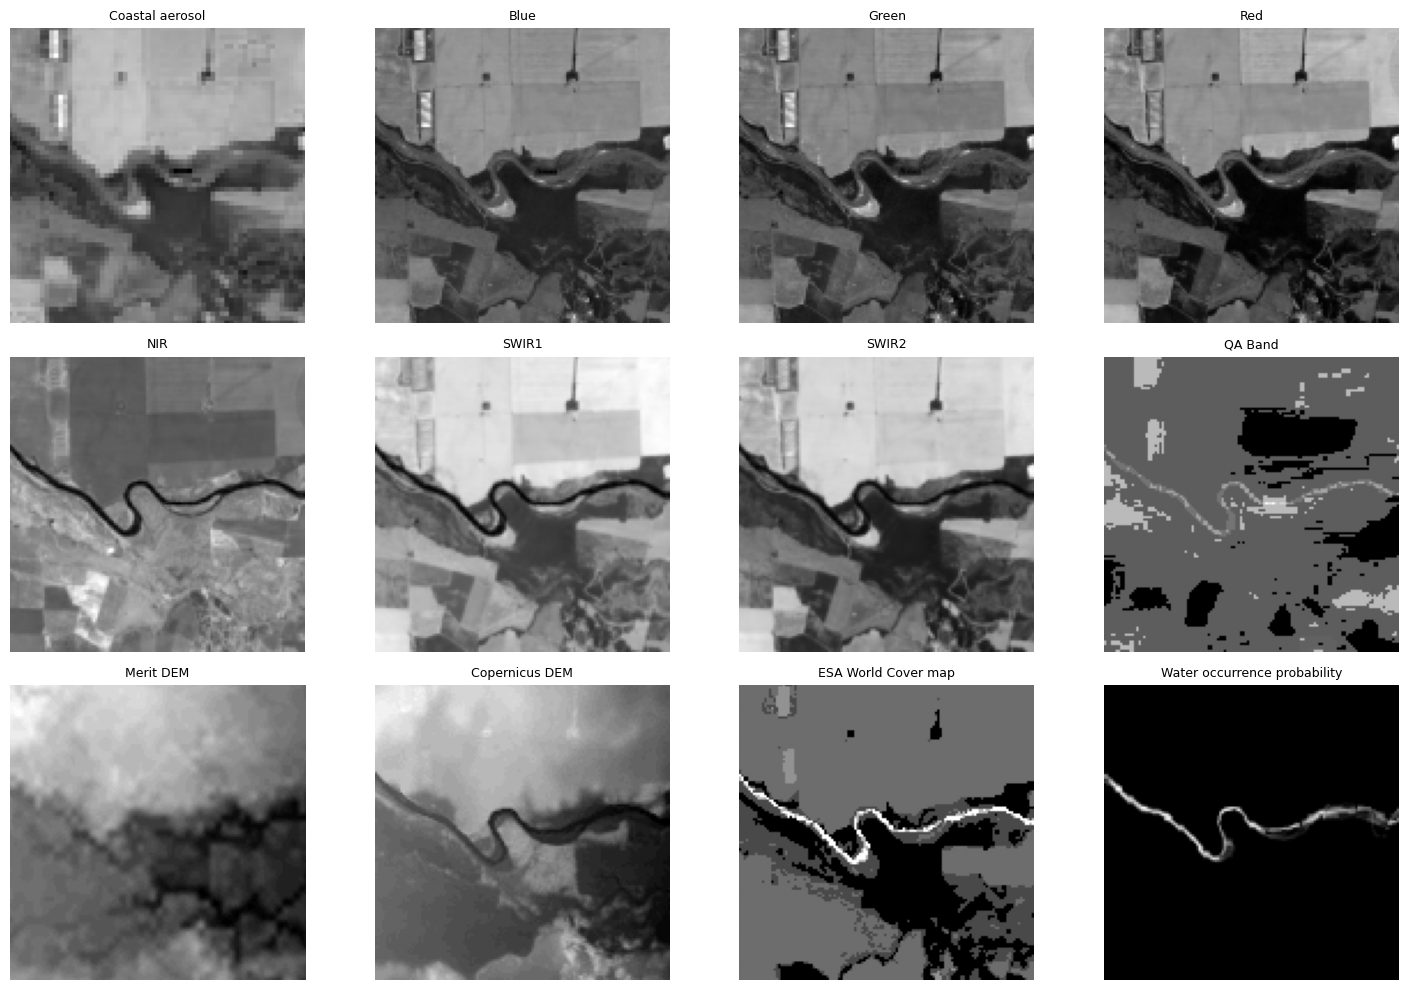

In [39]:
channel_names = [
    "Coastal aerosol",
    "Blue",
    "Green",
    "Red",
    "NIR",
    "SWIR1",
    "SWIR2",
    "QA Band",
    "Merit DEM",
    "Copernicus DEM",
    "ESA World Cover map",
    "Water occurrence probability"
]

img_files = os.listdir(image_dir)
img_path = os.path.join(image_dir, img_files[0])

with rasterio.open(img_path) as src:
    img = src.read()

print("Image shape:", img.shape)

num_channels = img.shape[0]
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i in range(num_channels):
    axes[i].imshow(img[i], cmap="gray")
    axes[i].set_title(channel_names[i], fontsize=9)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

📌 معنى كل قناة:

Band 2 (Blue)

حساسة جدًا للمياه الضحلة.

المياه بتمتص الضوء في الأزرق بشكل مميز مقارنة باليابسة.

Band 3 (Green)

بيساعد في التمييز بين المياه والنباتات.

الماء غالبًا بيبان غامق، لكن الغطاء النباتي بيبان أفتح.

Band 7 (NIR  Near Infrared)

أهم قناة للكشف عن المياه.

المياه بتمتص الـ NIR بقوة → بتظهر غامقة جدًا.

اليابسة والنباتات بيعكسوا الـ NIR → بيظهروا فاتحين.

In [40]:
best_channels = ["Blue", "Green", "Red", "NIR", "SWIR1"]
selected_channels = [channel_names.index(band) for band in best_channels]

def load_dataset(image_dir, label_dir, selected_channels=selected_channels, target_size=(128,128)):

    images, masks = [], []

    image_files = sorted(glob.glob(os.path.join(image_dir, "*.tif")))
    label_files = sorted(glob.glob(os.path.join(label_dir, "*.png")))

    image_names = [os.path.splitext(os.path.basename(f))[0] for f in image_files]
    label_names = [os.path.splitext(os.path.basename(f))[0] for f in label_files]
    common_names = sorted(set(image_names).intersection(set(label_names)))

    print(f"Found {len(image_files)} images, {len(label_files)} masks, {len(common_names)} common pairs.")

    for name in common_names:
        img_path = os.path.join(image_dir, name + ".tif")
        lbl_path = os.path.join(label_dir, name + ".png")

        if not os.path.exists(img_path) or not os.path.exists(lbl_path):
            continue

        with rasterio.open(img_path) as src:
            img = src.read()
            img = np.transpose(img, (1,2,0))
            img = img[:,:,selected_channels]

        img_resized = sk_resize(img, target_size, preserve_range=True)
        img_resized = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-6)

        mask = rasterio.open(lbl_path).read(1)
        mask = (mask > 0).astype(np.float32)

        mask_resized = sk_resize(mask, target_size, preserve_range=True, anti_aliasing=True)
        mask_resized = (mask_resized > 0.5).astype(np.float32)

        images.append(img_resized)
        masks.append(mask_resized)

    X = np.array(images, dtype=np.float32)
    Y = np.array(masks, dtype=np.float32)
    Y = np.expand_dims(Y, axis=-1)

    print("Dataset shape:", X.shape, Y.shape)
    return X, Y


X, Y = load_dataset(image_dir, label_dir)

Found 306 images, 455 masks, 306 common pairs.
Dataset shape: (306, 128, 128, 5) (306, 128, 128, 1)


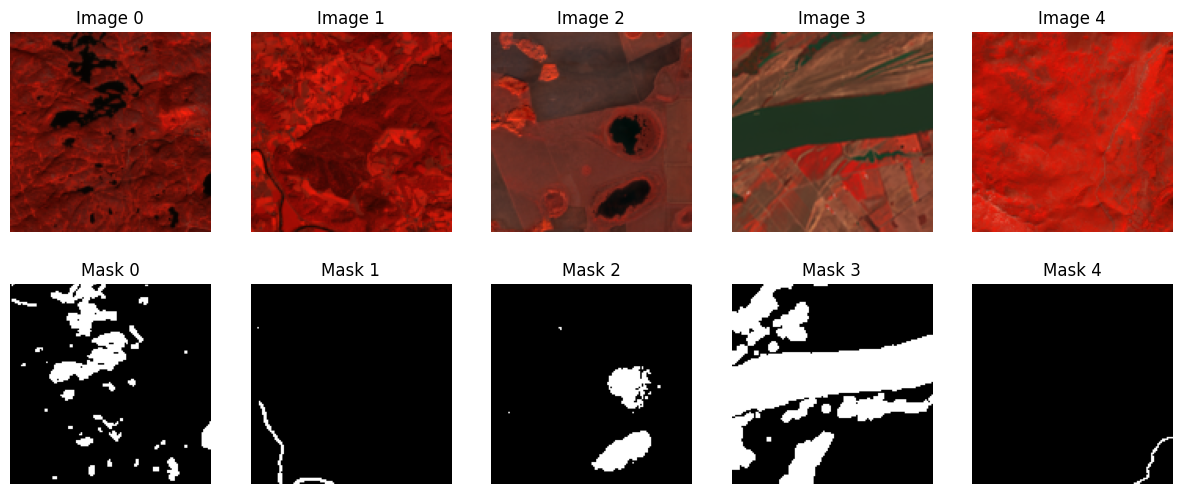

In [41]:
def preview_dataset(images, masks, n=5):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        img = images[i][:,:, [3,1,0]]

        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title(f"Image {i}")
        plt.axis("off")

        plt.subplot(2, n, i+1+n)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title(f"Mask {i}")
        plt.axis("off")
    plt.show()


preview_dataset(X, Y, n=5)


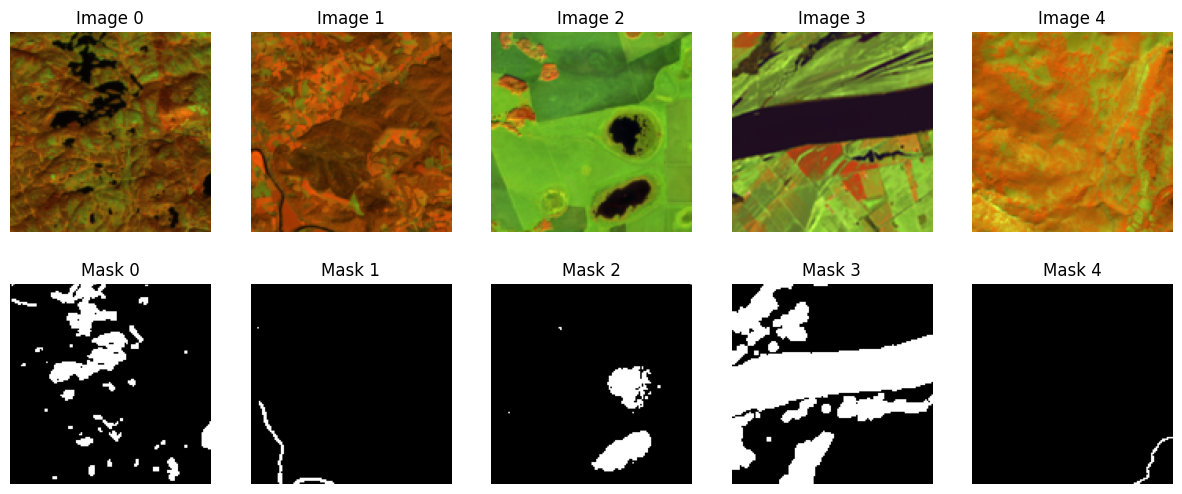

In [42]:
def preview_dataset2(images, masks, n=5):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        img = images[i][:,:, [3,4,0]]

        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title(f"Image {i}")
        plt.axis("off")

        plt.subplot(2, n, i+1+n)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title(f"Mask {i}")
        plt.axis("off")
    plt.show()

#
preview_dataset2(X, Y, n=5)

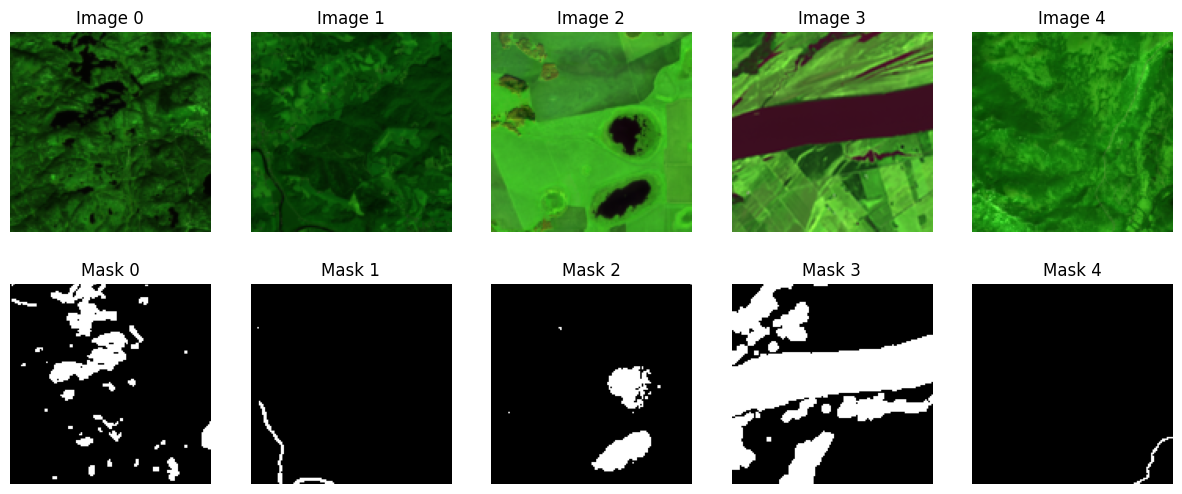

In [43]:
def preview_dataset3(images, masks, n=5):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        img = images[i][:,:, [2,4,0]]

        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title(f"Image {i}")
        plt.axis("off")

        plt.subplot(2, n, i+1+n)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title(f"Mask {i}")
        plt.axis("off")
    plt.show()


preview_dataset3(X, Y, n=5)

In [44]:
def preview_dataset4(images, masks, n=3, band_names=["Blue","Green","Red","NIR","SWIR1"]):
    for i in range(n):
        plt.figure(figsize=(15, 8))

        for j in range(images.shape[-1]):
            plt.subplot(2, images.shape[-1]//2 + 2, j+1)
            plt.imshow(images[i][:,:,j], cmap="gray")
            plt.title(f"{band_names[j]}")
            plt.axis("off")

        rgb_img = images[i][:,:, [2,1,0]]
        plt.subplot(2, images.shape[-1]//2 + 2, images.shape[-1]+1)
        plt.imshow(rgb_img)
        plt.title("RGB Composite")
        plt.axis("off")

        plt.subplot(2, images.shape[-1]//2 + 2, images.shape[-1]+2)
        plt.imshow(masks[i].squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.suptitle(f"Sample {i}", fontsize=14)
        plt.tight_layout()
        plt.show()



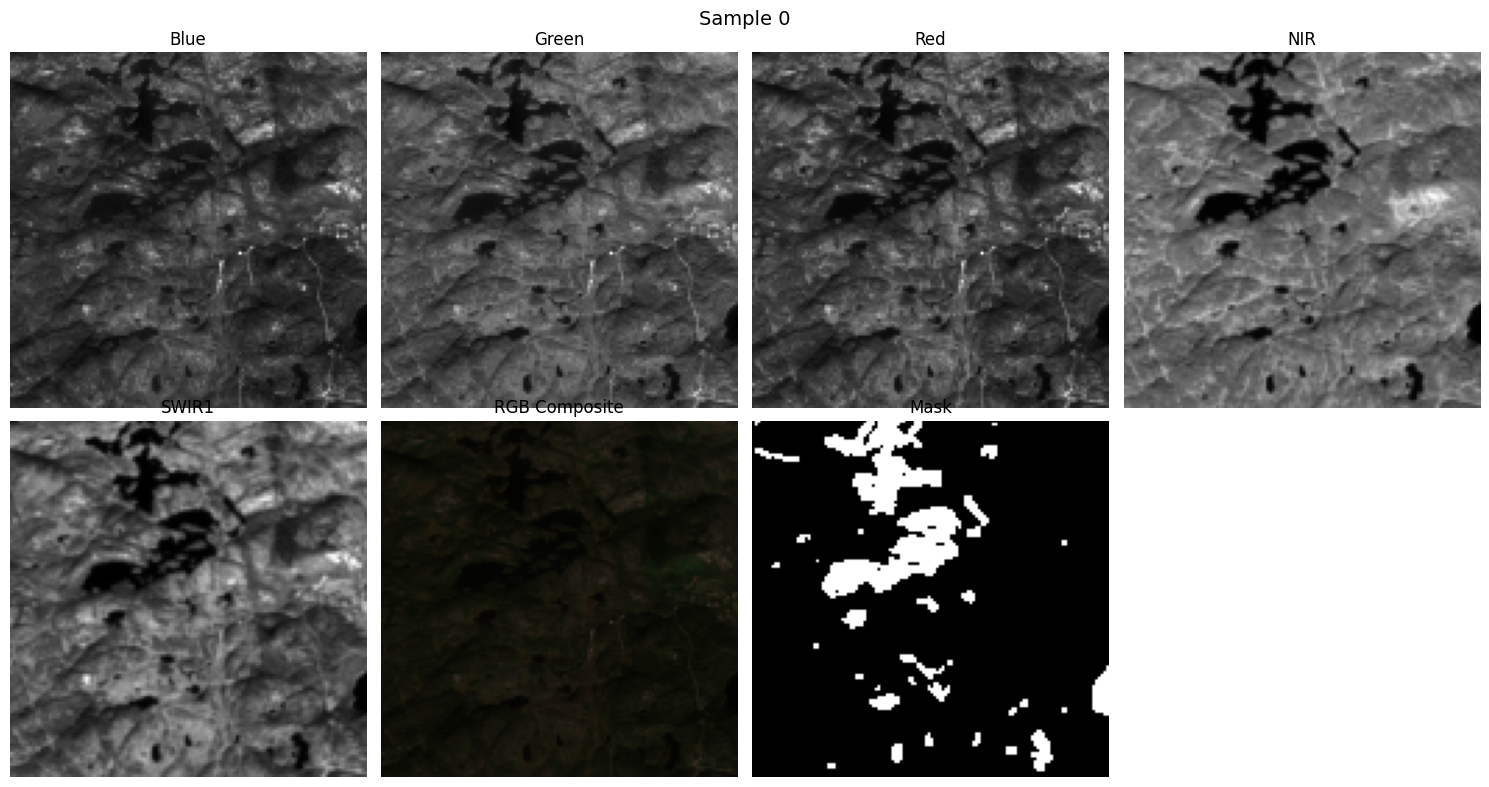

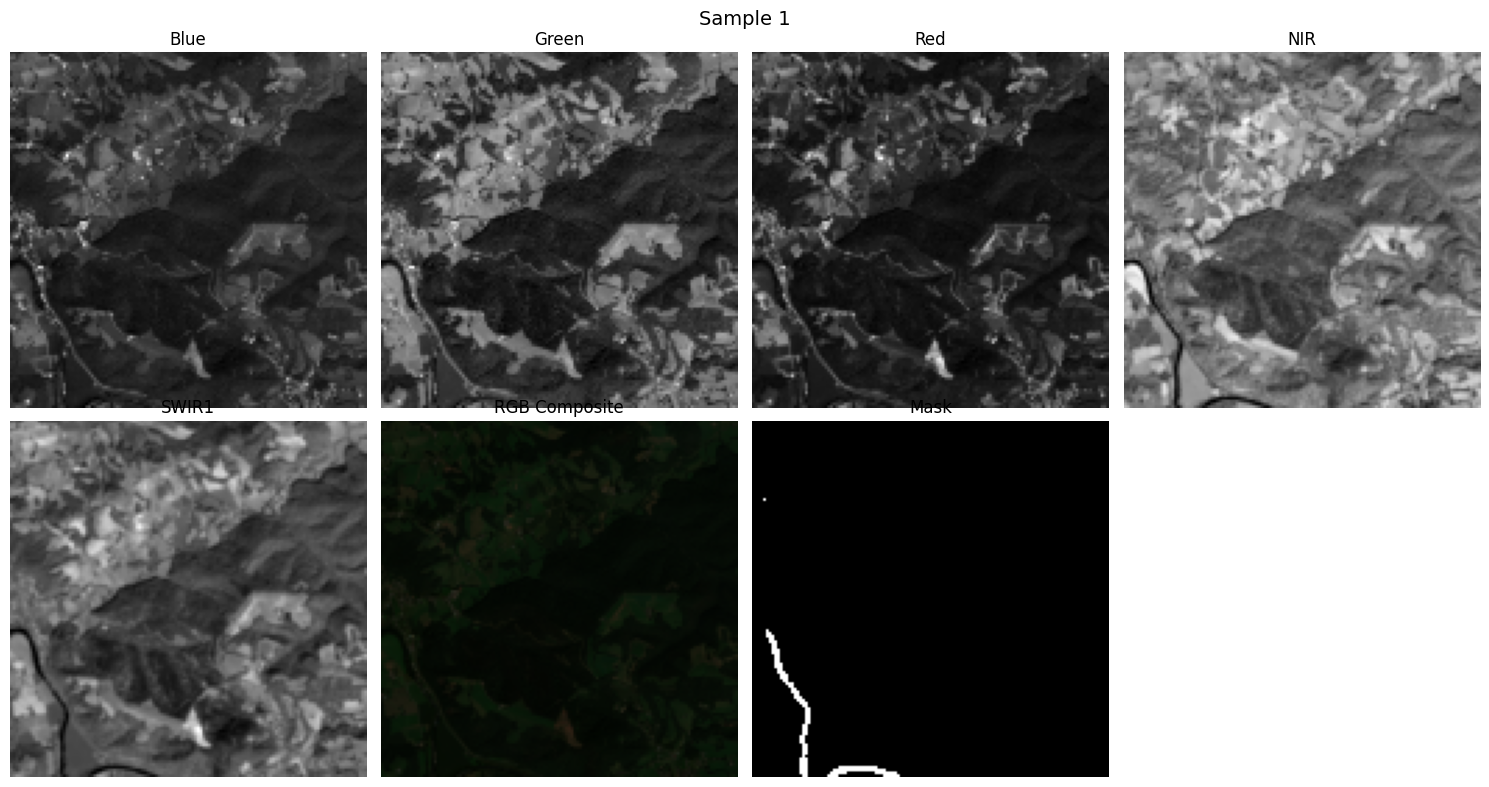

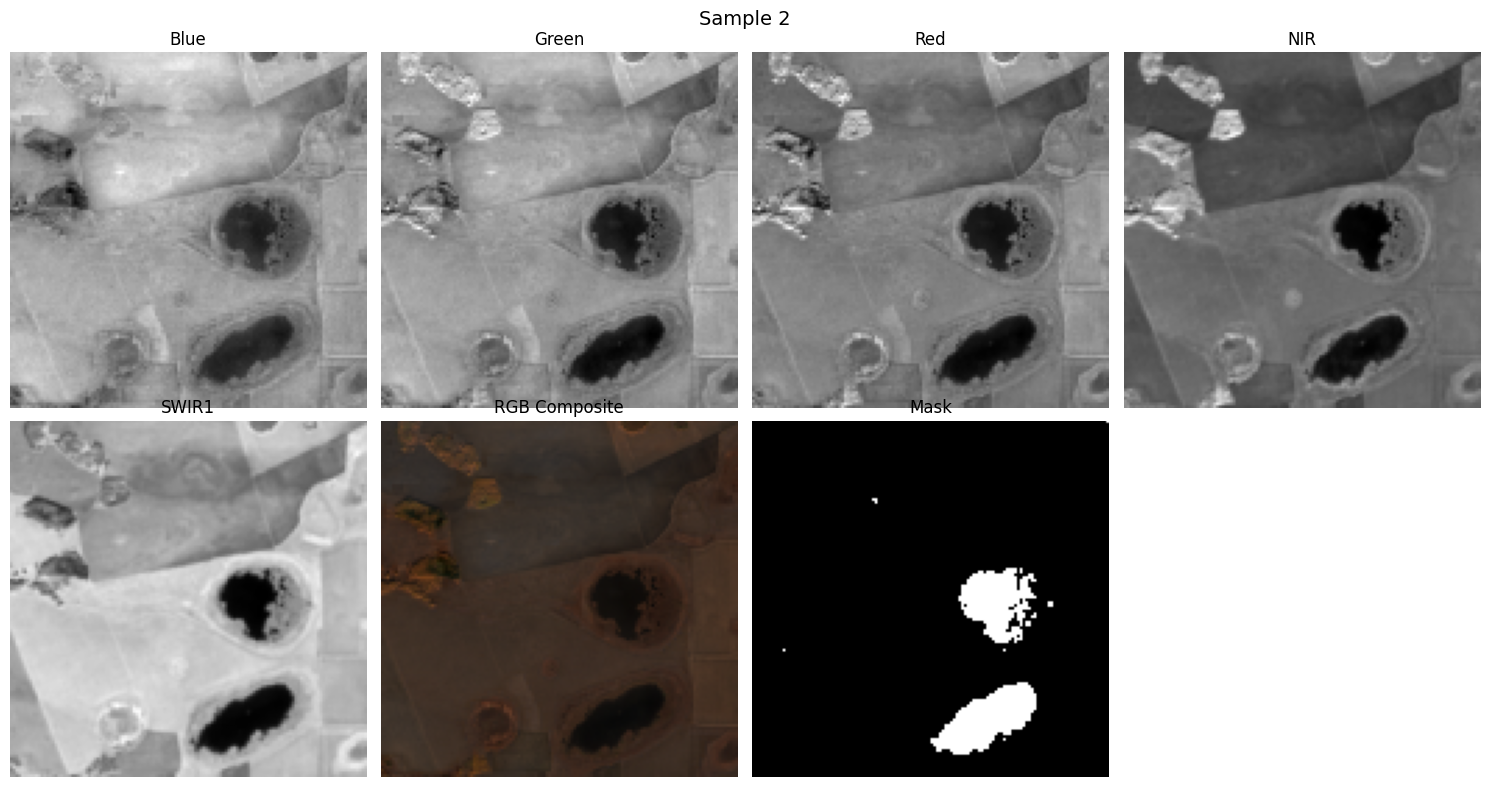

In [45]:
preview_dataset4(X, Y, n=3)

In [46]:
images = X.astype(np.float32) / 255.0
masks = Y.astype(np.float32)
masks = np.expand_dims(masks, axis=-1)

print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images shape: (306, 128, 128, 5)
Masks shape: (306, 128, 128, 1, 1)


In [47]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

In [48]:
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    X = layers.Conv2D(16, 3, activation="relu", padding="same")(inputs)
    X = layers.Conv2D(16, 3, activation="relu", padding="same")(X)
    X = layers.MaxPooling2D()(X)

    X = layers.Conv2D(32,3, activation="relu", padding="same")(X)
    X = layers.Conv2D(32,3, activation="relu", padding="same")(X)
    X = layers.MaxPooling2D()(X)

    X = layers.Conv2D(64,3, activation="relu", padding="same")(X)
    X = layers.Conv2D(64,3, activation="relu", padding="same")(X)

    X = layers.UpSampling2D()(X)
    X = layers.Concatenate()([X, X])
    X = layers.Conv2D(32, 3, activation="relu", padding="same")(X)
    X = layers.Conv2D(32, 3, activation="relu", padding="same")(X)

    X = layers.UpSampling2D()(X)
    X = layers.Concatenate()([X, X])
    X = layers.Conv2D(16, 3, activation="relu", padding="same")(X)
    X = layers.Conv2D(16,3, activation="relu", padding="same")(X)

    outputs = layers.Conv2D(1,1, activation="sigmoid")(X)

    model = models.Model(inputs, outputs)
    return model

model1 = unet_model(input_shape=X_train1.shape[1:])

model1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 5)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │        736 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_22[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_24[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_26[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 64, 64,    │          0 │ conv2d_27[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ up_sampling2d_4[… │
│ (Concatenate)       │ 128)              │            │ up_sampling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │     36,896 │ concatenate_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_28[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 128, 128,  │          0 │ conv2d_29[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 128,  │          0 │ up_sampling2d_5[… │
│ (Concatenate)       │ 64)               │            │ up_sampling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │      9,232 │ concatenate_5[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_30[0][0] 

 Total params: 130,081 (508.13 KB)

 Trainable params: 130,081 (508.13 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [50]:
checkpoint_path = "best_model.keras"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

In [51]:
history = model1.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=100,
    batch_size=8,
    callbacks= checkpoint
)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7047 - loss: 0.6530
Epoch 1: val_accuracy improved from -inf to 0.77563, saving model to best_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.7055 - loss: 0.6521 - val_accuracy: 0.7756 - val_loss: 0.5351
Epoch 2/100
28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7240 - loss: 0.5983
Epoch 2: val_accuracy did not improve from 0.77563
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7247 - loss: 0.5973 - val_accuracy: 0.7756 - val_loss: 0.5363
Epoch 3/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7589 - loss: 0.5574
Epoch 3: val_accuracy did not improve from 0.77563
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7561 - loss: 0.5598 - val_accuracy: 0.7756 - val_loss: 0.5113
Epoch 4/100
29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7524 - loss: 0.4910
Epoch 4: val_accuracy did not improve from 0.77563
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7502 - loss: 

In [52]:
loss, acc = model1.evaluate(X_test1, y_test1)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9063 - loss: 0.2598
Test Loss: 0.2654, Test Accuracy: 0.9033


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94    787894
           1       0.82      0.73      0.77    227914

    accuracy                           0.90   1015808
   macro avg       0.87      0.84      0.85   1015808
weighted avg       0.90      0.90      0.90   1015808



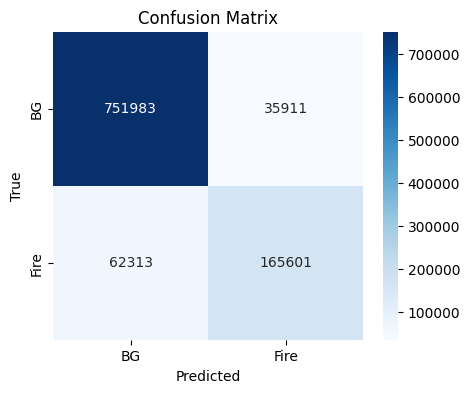

IoU: 0.6277


In [53]:
y_pred = model1.predict(X_test1)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
y_true_binary = y_test1.astype(int).flatten()

print("\nClassification Report:")
print(classification_report(y_true_binary, y_pred_binary))

cm = confusion_matrix(y_true_binary, y_pred_binary)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["BG","Fire"], yticklabels=["BG","Fire"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

tn, fp, fn, tp = cm.ravel()
iou = tp / (tp + fp + fn)
print(f"IoU: {iou:.4f}")

In [55]:
import numpy as np
import random
import matplotlib.pyplot as plt

def test_prediction(model, X_test1, y_test1, n=3):

    for i in range(n):
        idx = random.randint(0, len(X_test1)-1)
        image = X_test1[idx]
        mask_true = y_test1[idx]

        # توقع الماسك واضغط الأبعاد
        mask_pred = model.predict(image[np.newaxis, ...])
        mask_pred = (mask_pred > 0.5).astype(int)
        mask_pred = np.squeeze(mask_pred)   # يخليها (128,128)

        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(image[:,:,0], cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(np.squeeze(mask_true), cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(mask_pred, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


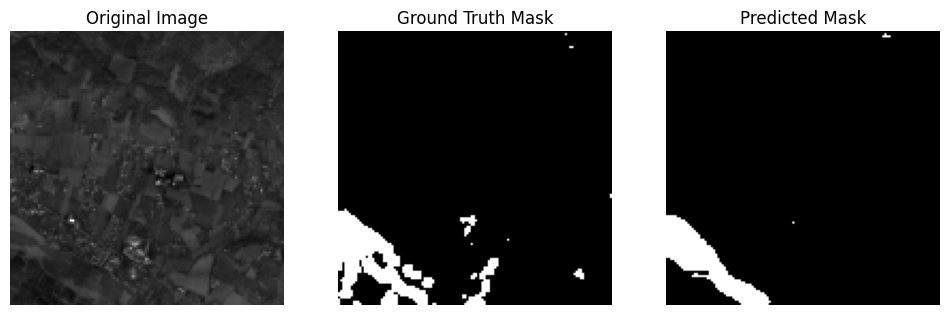

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


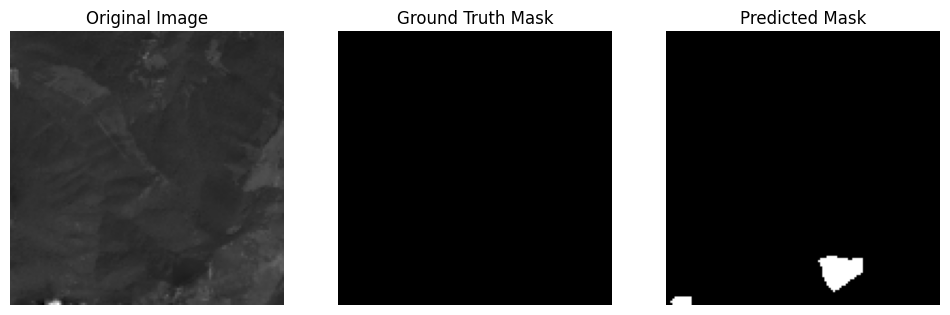

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


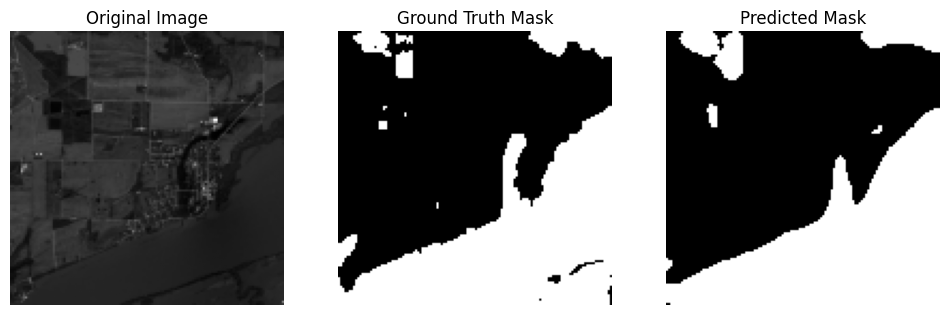

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


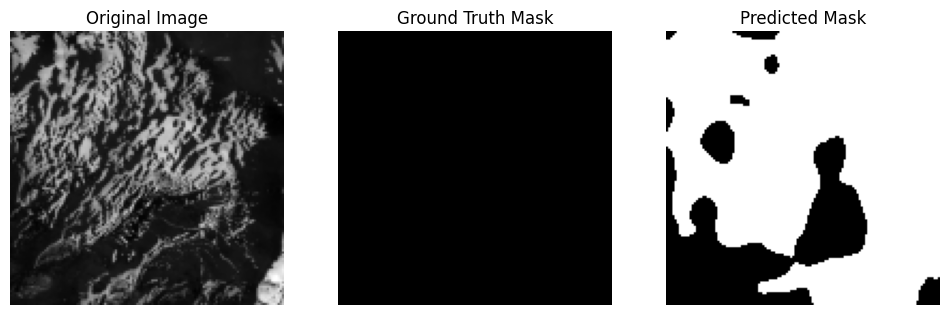

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


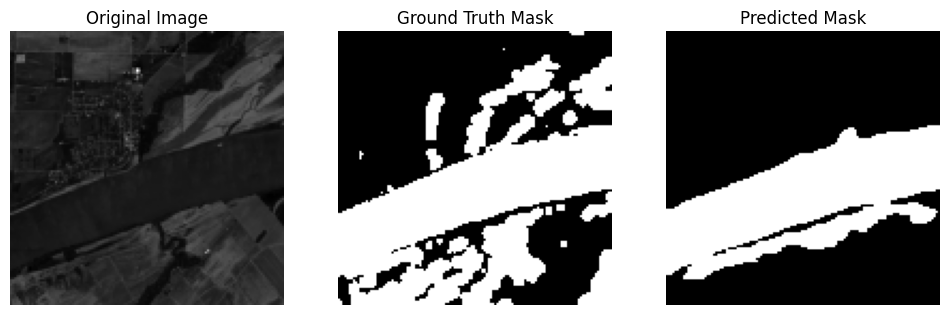

In [56]:
test_prediction(model1, X_test1, y_test1, n=5)


In [57]:
zip_path = "data.zip"
extract_path = "data_extracted2"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [58]:
image_dir2 = os.path.join(extract_path, "data/images")
label_dir2 = os.path.join(extract_path, "data/labels")
print(os.listdir(extract_path))
print(os.listdir(image_dir2))
print(os.listdir(label_dir2))

['data']
['87.tif', '199.tif', '162.tif', '193.tif', '75.tif', '172.tif', '13.tif', '268.tif', '47.tif', '155.tif', '102.tif', '191.tif', '251.tif', '67.tif', '17.tif', '242.tif', '256.tif', '209.tif', '22.tif', '60.tif', '293.tif', '296.tif', '19.tif', '281.tif', '214.tif', '77.tif', '34.tif', '4.tif', '236.tif', '271.tif', '235.tif', '156.tif', '40.tif', '275.tif', '64.tif', '273.tif', '128.tif', '129.tif', '224.tif', '63.tif', '98.tif', '194.tif', '173.tif', '24.tif', '105.tif', '228.tif', '35.tif', '134.tif', '78.tif', '154.tif', '133.tif', '269.tif', '279.tif', '225.tif', '143.tif', '91.tif', '42.tif', '117.tif', '302.tif', '289.tif', '74.tif', '116.tif', '11.tif', '226.tif', '189.tif', '220.tif', '104.tif', '125.tif', '110.tif', '223.tif', '68.tif', '175.tif', '27.tif', '270.tif', '153.tif', '249.tif', '16.tif', '26.tif', '112.tif', '161.tif', '121.tif', '69.tif', '206.tif', '208.tif', '3.tif', '101.tif', '86.tif', '48.tif', '217.tif', '280.tif', '100.tif', '177.tif', '211.tif', 

In [59]:
label_dir2 = os.path.join(extract_path, "data/labels")

for filename in os.listdir(label_dir2):
    new_name = filename.replace("_", "")
    old_path = os.path.join(label_dir2, filename)
    new_path = os.path.join(label_dir2, new_name)
    os.rename(old_path, new_path)

print("Renamed masks:", os.listdir(label_dir2)[:10])


Renamed masks: ['163.png', '26.png', '5343.png', '13556.png', '8.png', '218.png', '36240.png', '19.png', '141.png', '71.png']


In [60]:
channel_names = [
    "Coastal aerosol",
    "Blue",
    "Green",
    "Red",
    "NIR",
    "SWIR1",
    "SWIR2",
    "QA Band",
    "Merit DEM",
    "Copernicus DEM",
    "ESA World Cover map",
    "Water occurrence probability"
]

def load_dataset(image_dir2, label_dir2, target_size=(128,128)):
    images, masks = [], []

    image_files = sorted(glob.glob(os.path.join(image_dir2, "*.tif")))
    label_files = sorted(glob.glob(os.path.join(label_dir2, "*.png")))

    image_names = [os.path.splitext(os.path.basename(f))[0] for f in image_files]
    label_names = [os.path.splitext(os.path.basename(f))[0] for f in label_files]
    common_names = sorted(set(image_names).intersection(set(label_names)))

    print(f"Found {len(image_files)} images, {len(label_files)} masks, {len(common_names)} common pairs.")

    for name in common_names:
        img_path = os.path.join(image_dir2, name + ".tif")
        lbl_path = os.path.join(label_dir2, name + ".png")

        if not os.path.exists(img_path) or not os.path.exists(lbl_path):
            continue

        with rasterio.open(img_path) as src:
            img = src.read()
            img = np.transpose(img, (1,2,0))

        img_resized = sk_resize(img, target_size, preserve_range=True)
        img_resized = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-6)

        mask = rasterio.open(lbl_path).read(1)
        mask_resized = sk_resize(mask, target_size, preserve_range=True, anti_aliasing=True)
        mask_resized = (mask_resized > 0.5).astype(np.float32)

        images.append(img_resized)
        masks.append(mask_resized)

    X = np.array(images, dtype=np.float32)
    Y = np.array(masks, dtype=np.float32)
    Y = np.expand_dims(Y, axis=-1)

    print("Dataset shape:", X.shape, Y.shape)
    return X, Y

X, Y = load_dataset(image_dir2, label_dir2)


Found 306 images, 455 masks, 306 common pairs.


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Dataset shape: (306, 128, 128, 12) (306, 128, 128, 1)


In [63]:
import tensorflow as tf
from tensorflow.keras import layers, models

def ChannelSelector(input_shape, top_k=3):
    inputs = layers.Input(shape=input_shape)

    # 1x1 Conv = وزن لكل قناة
    weights = layers.Conv2D(1, (1,1), use_bias=False, name="channel_weights")(inputs)

    # متوسط الأوزان (channel importance)
    channel_scores = layers.Lambda(lambda x: tf.reduce_mean(x, axis=[0,1]), name="channel_scores")(weights)

    # موديل بمخرجين
    model = models.Model(inputs, [weights, channel_scores], name="ChannelSelector")
    return model

# نبني الموديل
model = ChannelSelector((128,128,X.shape[-1]), top_k=3)

# Compile: نحدد خسارة لكل output
model.compile(
    optimizer="adam",
    loss={
        "channel_weights": "binary_crossentropy",   # للـ segmentation
        "channel_scores": None                      # ما فيش loss هنا
    },
    metrics={"channel_weights": "accuracy"}
)

# Train (محتاج نوفر target للـ output الثاني حتى لو dummy)
history = model.fit(
    X,
    {"channel_weights": Y, "channel_scores": tf.zeros((len(X), X.shape[-1]))},
    epochs=5, batch_size=8, validation_split=0.2
)

# بعد التدريب: استرجاع أوزان القنوات
channel_layer = model.get_layer("channel_weights")
weights = channel_layer.get_weights()[0]   # (1,1,num_channels,1)
weights = weights.squeeze()                # (num_channels,)

# أفضل 3 قنوات
top_values, top_indices = tf.math.top_k(weights, k=3)
print("Top 3 Channels:")
for idx, val in zip(top_indices.numpy(), top_values.numpy()):
    print(f"{channel_names[idx]} -> Score: {val:.4f}")


Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - channel_weights_accuracy: 0.7257 - loss: 1.8617 - val_channel_weights_accuracy: 0.7796 - val_loss: 1.6480
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - channel_weights_accuracy: 0.7380 - loss: 1.5948 - val_channel_weights_accuracy: 0.7796 - val_loss: 1.4326
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - channel_weights_accuracy: 0.7629 - loss: 1.3819 - val_channel_weights_accuracy: 0.7796 - val_loss: 1.1276
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - channel_weights_accuracy: 0.7523 - loss: 1.2936 - val_channel_weights_accuracy: 0.7796 - val_loss: 0.8523
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - channel_weights_accuracy: 0.7423 - loss: 0.9324 - val_channel_weights_accuracy: 0.7797 - val_loss: 0.6257
Top 3 Channels:
Red -> Score: 0.5739
Green -> Score: 0.4796
Merit DEM -> Score: 0.4469


In [68]:
def preview_channels_separately(images, masks, selected_channels, n=3):
    import numpy as np

    # لو selected_channels أسماء → حولها ل indices
    if isinstance(selected_channels[0], str):
        selected_channels = [channel_names.index(ch) for ch in selected_channels]

    num_channels = len(selected_channels)
    plt.figure(figsize=(5 * num_channels, 4 * n))

    for i in range(n):
        for j, ch in enumerate(selected_channels):
            img = images[i][:,:,ch]
            img_disp = (img - img.min()) / (img.max() - img.min() + 1e-6)

            plt.subplot(n, num_channels*2, i*num_channels*2 + j*2 + 1)
            plt.imshow(img_disp, cmap="gray")
            plt.title(f"Image {i} - {channel_names[ch]}")
            plt.axis("off")

            plt.subplot(n, num_channels*2, i*num_channels*2 + j*2 + 2)
            plt.imshow(masks[i].squeeze(), cmap="gray")
            plt.title("Mask")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


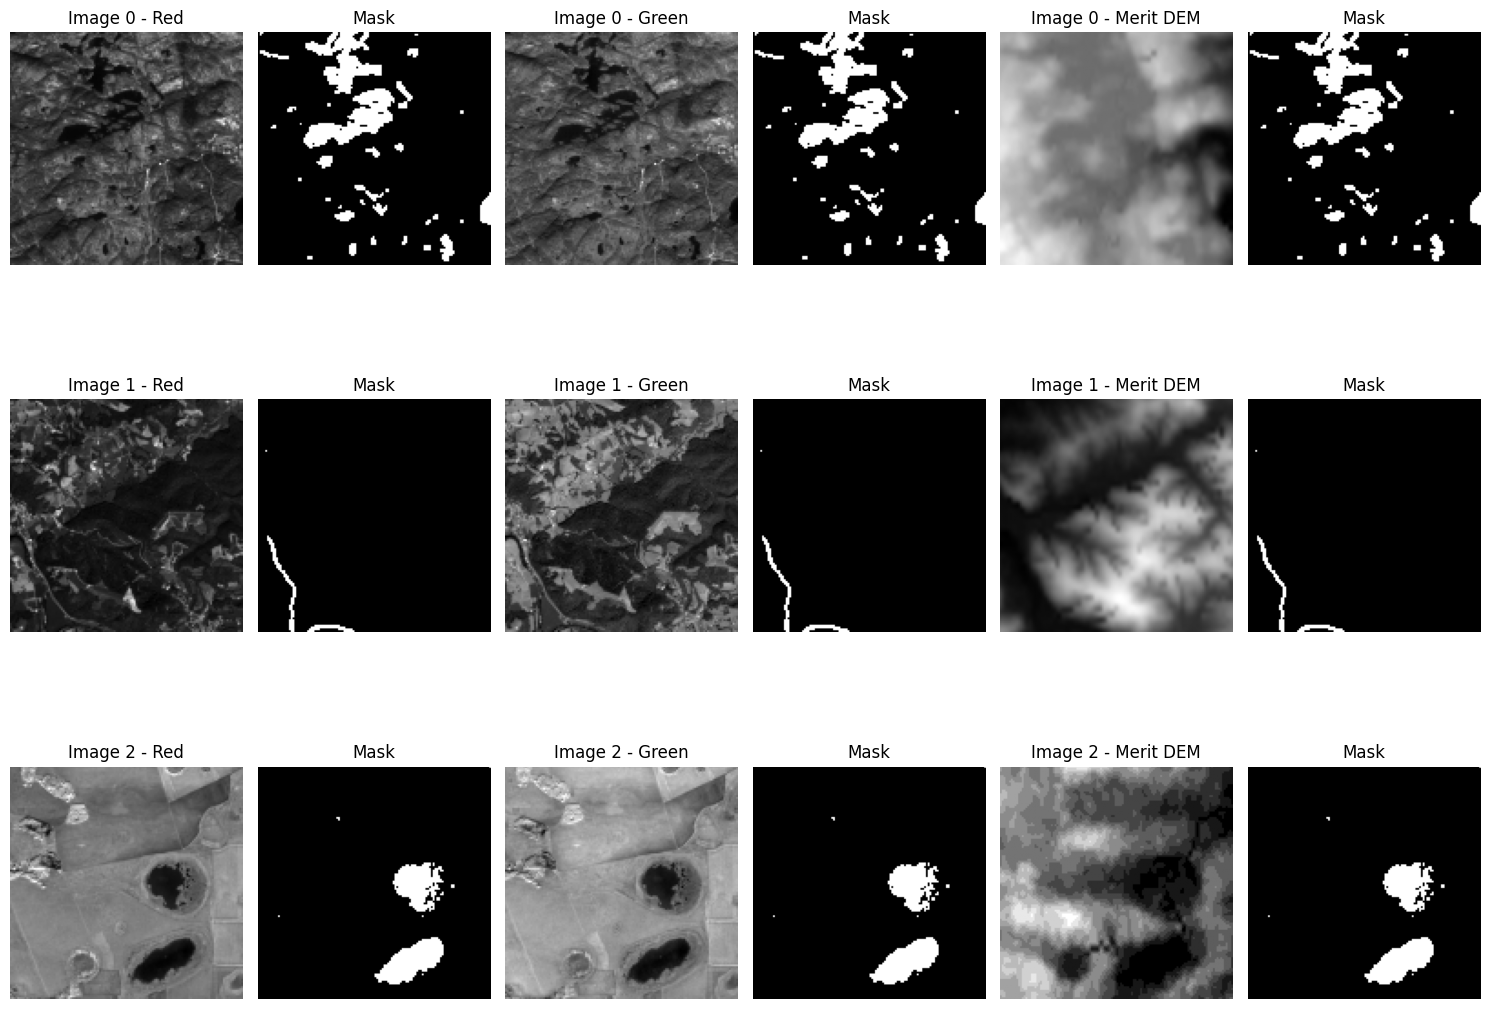

In [69]:
best_channels = ["Red", "Green", "Merit DEM"]

best_channels_idx = [channel_names.index(ch) for ch in best_channels]

preview_channels_separately(X, Y, best_channels_idx, n=3)


In [70]:
X_selected = X[:,:,:,best_channels_idx]

print("Original X shape:", X.shape)
print("Selected X shape:", X_selected.shape)


Original X shape: (306, 128, 128, 12)
Selected X shape: (306, 128, 128, 3)


In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X_selected, Y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, Y_train.shape)
print("Test shape:", X_test.shape, Y_test.shape)


Train shape: (244, 128, 128, 3) (244, 128, 128, 1)
Test shape: (62, 128, 128, 3) (62, 128, 128, 1)


In [73]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_resnet34(input_shape=(128,128,3), num_classes=1):
    # Load Pretrained ResNet34 من keras.applications (هنا هنستخدم ResNet50 كبديل لأن ResNet34 مش موجود رسمي في keras)
    base_model = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_shape=input_shape
    )

    # نحدد ال layers اللي هنستخدمها في الـ skip connections
    skips = [
        base_model.get_layer("conv1_relu").output,   # 64 filters
        base_model.get_layer("conv2_block3_out").output,  # 256 filters
        base_model.get_layer("conv3_block4_out").output,  # 512 filters
        base_model.get_layer("conv4_block6_out").output,  # 1024 filters
    ]
    encoder_output = base_model.get_layer("conv5_block3_out").output  # 2048 filters

    # Decoder (Upsampling + Skip connections)
    x = encoder_output
    for skip in reversed(skips):
        x = layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding="same")(x)
        x = layers.concatenate([x, skip])
        x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
        x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)

    # Final upsampling
    x = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding="same")(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)

    outputs = layers.Conv2D(num_classes, (1,1), activation="sigmoid")(x)

    model = models.Model(inputs=base_model.input, outputs=outputs, name="U-Net_ResNet50")
    return model



In [74]:
model = build_resnet34(input_shape=(128,128,3), num_classes=1)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [75]:
checkpoint_path = "resnet34_model.keras"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

In [77]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)]
)

model.summary()

Model: "U-Net_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 39,442,561 (150.46 MB)

 Trainable params: 39,389,441 (150.26 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [78]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=100,
    batch_size=8,
    callbacks=checkpoint
)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6818 - loss: 0.9586 - mean_io_u_1: 0.3729   
Epoch 1: val_accuracy improved from -inf to 0.32477, saving model to resnet34_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.6827 - loss: 0.9511 - mean_io_u_1: 0.3726 - val_accuracy: 0.3248 - val_loss: 10.4828 - val_mean_io_u_1: 0.3832
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6715 - loss: 0.6564 - mean_io_u_1: 0.3710
Epoch 2: val_accuracy did not improve from 0.32477
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.6731 - loss: 0.6545 - mean_io_u_1: 0.3708 - val_accuracy: 0.2339 - val_loss: 327.8961 - val_mean_io_u_1: 0.1311
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7332 - loss: 0.5966 - mean_io_u_1: 0.3567
Epoch 3: val_accuracy improved from 0.32477 to 0.61570, saving model to resnet34_model.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - accuracy: 0.7332 - loss: 0.5964 - mean_io_u_1: 0.3570 - val_acc

2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 20s/step - accuracy: 0.9179 - loss: 0.2243 - mean_io_u_1: 0.3959
Test Loss: 0.2345
Test Accuracy: 0.9138
Test Mean IoU: 0.3878
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95    787894
         1.0       0.86      0.74      0.79    227914

    accuracy                           0.91   1015808
   macro avg       0.89      0.85      0.87   1015808
weighted avg       0.91      0.91      0.91   1015808



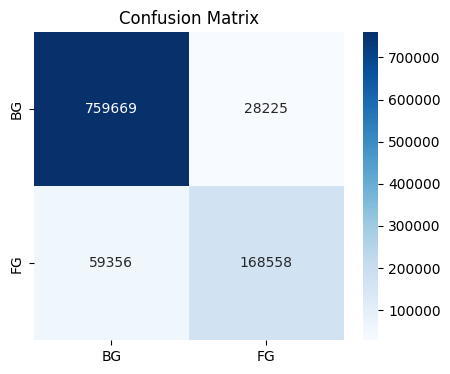

Average IoU over test set: 0.5007


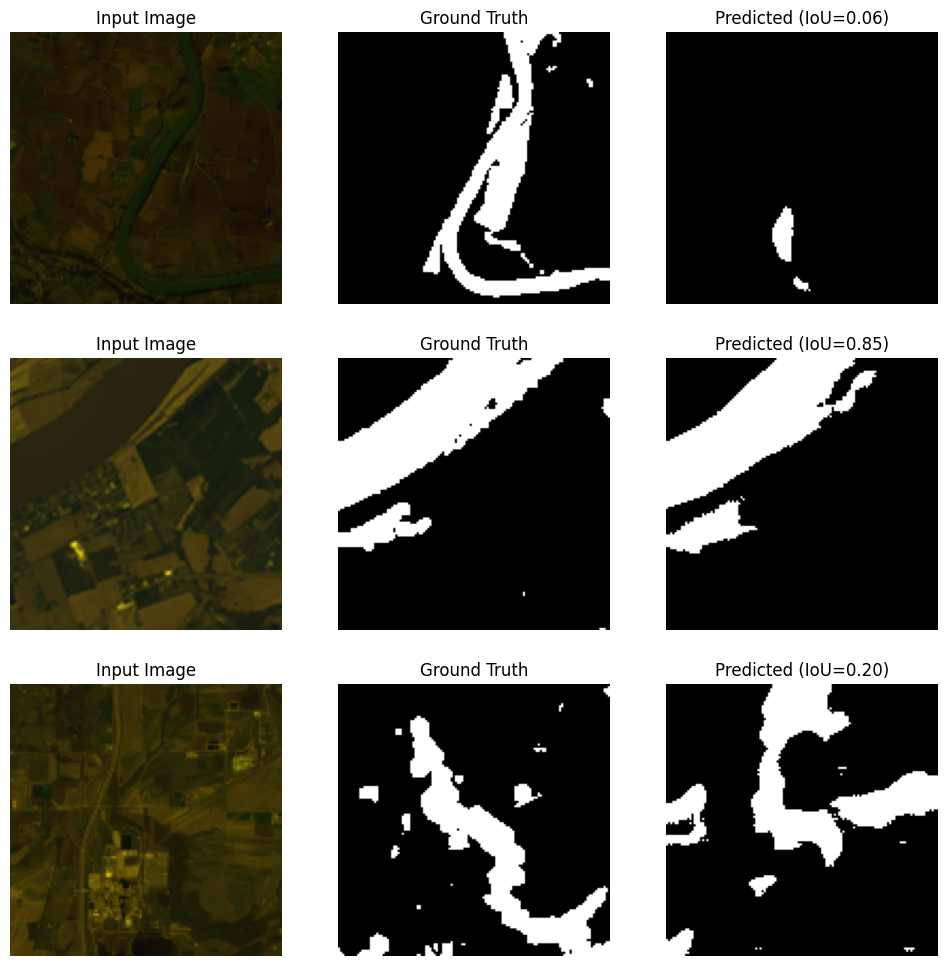

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf

# 1) Evaluate model على test set
test_loss, test_acc, test_iou = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Mean IoU: {test_iou:.4f}")

# 2) Get predictions
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(int)

# Flatten for metrics
y_true_flat = Y_test.flatten()
y_pred_flat = y_pred_bin.flatten()

# 3) Classification report
print("\nClassification Report:")
print(classification_report(y_true_flat, y_pred_flat))

# 4) Confusion Matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["BG","FG"], yticklabels=["BG","FG"])
plt.title("Confusion Matrix")
plt.show()

# 5) IoU function
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 1.0
    return intersection / union

# IoU لكل صورة
ious = []
for i in range(len(X_test)):
    iou = compute_iou(Y_test[i].squeeze(), y_pred_bin[i].squeeze())
    ious.append(iou)

print(f"Average IoU over test set: {np.mean(ious):.4f}")

# 6) Visualization
def visualize_predictions(X, Y, preds, n=3):
    plt.figure(figsize=(12, n*4))
    for i in range(n):
        iou = compute_iou(Y[i].squeeze(), preds[i].squeeze())

        # الصورة الأصلية
        plt.subplot(n,3,3*i+1)
        plt.imshow(X[i])
        plt.title("Input Image")
        plt.axis("off")

        # الماسك الحقيقي
        plt.subplot(n,3,3*i+2)
        plt.imshow(Y[i].squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        # الماسك المتوقع
        plt.subplot(n,3,3*i+3)
        plt.imshow(preds[i].squeeze(), cmap="gray")
        plt.title(f"Predicted (IoU={iou:.2f})")
        plt.axis("off")
    plt.show()

visualize_predictions(X_test, Y_test, y_pred_bin, n=3)


In [80]:
# Cell 1: imports and quick checks
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)

# تأكد إن X_selected موجود (صور مع القنوات المختارة)
try:
    X_selected
    print("Found X_selected in workspace.")
except NameError:
    try:
        # حاول بناءه من X و best_channels_idx لو موجودين
        best_channels_idx
        X_selected = X[:,:,:,best_channels_idx]
        print("Built X_selected from X and best_channels_idx.")
    except Exception as e:
        raise NameError(
            "X_selected غير معرف. الرجاء تعريفه قبل تشغيل الخلايا. "
            "مثلاً: X_selected = X[:,:,:,best_channels_idx]"
        )

# تأكد من Y موجودة
try:
    Y
except NameError:
    raise NameError("Y (masks) غير معرف. حمّل الماسكات في متغيّر Y قبل المتابعة.")

print("X_selected shape:", X_selected.shape)
print("Y shape:", Y.shape)


TensorFlow version: 2.19.0
Found X_selected in workspace.
X_selected shape: (306, 128, 128, 3)
Y shape: (306, 128, 128, 1)


In [81]:
# Cell 2: split into train / val / test (70/15/15)
test_frac = 0.15
val_frac = 0.15

# 1) فصل test
X_tmp, X_test, Y_tmp, Y_test = train_test_split(
    X_selected, Y, test_size=test_frac, random_state=42, shuffle=True
)

# 2) من اللي فضل، نأخذ val بنسبة نسبية = val_frac / (1-test_frac)
val_rel = val_frac / (1 - test_frac)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_tmp, Y_tmp, test_size=val_rel, random_state=42, shuffle=True
)

print("Train:", X_train.shape, Y_train.shape)
print("Val:  ", X_val.shape, Y_val.shape)
print("Test: ", X_test.shape, Y_test.shape)


Train: (214, 128, 128, 3) (214, 128, 128, 1)
Val:   (46, 128, 128, 3) (46, 128, 128, 1)
Test:  (46, 128, 128, 3) (46, 128, 128, 1)


In [82]:
# Cell 3: build U-Net with ResNet50 encoder (pretrained on ImageNet)
from tensorflow.keras import layers, models

def build_unet_resnet50(input_shape=(128,128,3), num_classes=1):
    base_model = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_shape=input_shape
    )

    # skip layers (الأسماء مناسبة لإصدار Keras الحالي)
    skips = [
        base_model.get_layer("conv1_relu").output,        # stage1
        base_model.get_layer("conv2_block3_out").output,  # stage2
        base_model.get_layer("conv3_block4_out").output,  # stage3
        base_model.get_layer("conv4_block6_out").output,  # stage4
    ]
    encoder_output = base_model.get_layer("conv5_block3_out").output  # bottleneck

    x = encoder_output
    # decoder: نعمل upsample + concatenate مع skip
    for skip in reversed(skips):
        x = layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding="same")(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
        x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)

    # upsample to input resolution
    x = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding="same")(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)

    outputs = layers.Conv2D(num_classes, (1,1), activation="sigmoid")(x)

    model = models.Model(inputs=base_model.input, outputs=outputs, name="UNet_ResNet50")
    return model

# build
input_shape = X_train.shape[1:]  # (128,128,3) expected
model = build_unet_resnet50(input_shape=input_shape, num_classes=1)
model.summary()


Model: "UNet_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 39,442,561 (150.46 MB)

 Trainable params: 39,389,441 (150.26 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [83]:
# Cell 4: loss and compile
from tensorflow.keras.optimizers import Adam

# Dice loss (numerical stable)
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1.0 - (2.0 * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    # bce returns per-pixel loss; ensure shape compatibility
    bce = tf.reduce_mean(bce)
    return bce + dice_loss(y_true, y_pred)

# optimizer: AdamW (use tf.keras.optimizers.AdamW if available)
try:
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)
except Exception:
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # fallback

model.compile(
    optimizer=optimizer,
    loss=bce_dice_loss,
    metrics=["binary_accuracy", tf.keras.metrics.MeanIoU(num_classes=2)]
)

print("Compiled model with BCE + Dice loss and AdamW (or Adam fallback).")


Compiled model with BCE + Dice loss and AdamW (or Adam fallback).


In [84]:
# Cell 5: augmentation and tf.data pipeline
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 8

preprocess_fn = tf.keras.applications.resnet.preprocess_input  # ResNet preprocessing

def augment_and_preprocess(image, mask):
    # image, mask are tensors from from_tensor_slices (dtype may be float32 already)
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)

    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random 90-degree rotation
    if tf.random.uniform(()) > 0.5:
        k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)
        mask = tf.image.rot90(mask, k)

    # Random brightness (image only)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, max_delta=0.15)

    # (optionally) add a little gaussian noise
    if tf.random.uniform(()) > 0.7:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01)
        image = image + noise

    # preprocess for ResNet: expects pixels in [-mean,..] or scaled; our images are 0..1 -> scale to 0..255
    image = image * 255.0
    image = preprocess_fn(image)

    return image, mask

def preprocess_only(image, mask):
    image = tf.cast(image, tf.float32)
    mask = tf.cast(mask, tf.float32)
    image = image * 255.0
    image = preprocess_fn(image)
    return image, mask

# Build datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = train_ds.shuffle(2048, seed=42).map(augment_and_preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_ds = val_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds = test_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

print("Datasets ready: train/val/test")


Datasets ready: train/val/test


In [89]:
# Cell 6: callbacks
checkpoint_path = "resnet50.keras"

callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    #tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_binary_accuracy", save_best_only=True, verbose=1)
]

print("Callbacks set. Saving best model to:", checkpoint_path)


Callbacks set. Saving best model to: resnet50.keras


In [90]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - binary_accuracy: 0.8822 - loss: 0.5552 - mean_io_u_2: 0.3573
Epoch 1: val_binary_accuracy improved from -inf to 0.90475, saving model to resnet50.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 854ms/step - binary_accuracy: 0.8821 - loss: 0.5561 - mean_io_u_2: 0.3575 - val_binary_accuracy: 0.9048 - val_loss: 0.5582 - val_mean_io_u_2: 0.3730
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - binary_accuracy: 0.8961 - loss: 0.5568 - mean_io_u_2: 0.3793
Epoch 2: val_binary_accuracy did not improve from 0.90475
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - binary_accuracy: 0.8959 - loss: 0.5561 - mean_io_u_2: 0.3787 - val_binary_accuracy: 0.9005 - val_loss: 0.5721 - val_mean_io_u_2: 0.3730
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - binary_accuracy: 0.8815 - loss: 0.5541 - mean_io_u_2: 0.3651
Epoch 3: val_binary_accuracy did not improve from 0.90475
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - binary_accuracy: 0.8817 - loss: 0.5530 - me

In [91]:
# Cell 8: load best weights/model and evaluate
if os.path.exists(checkpoint_path):
    model = tf.keras.models.load_model(
        checkpoint_path,
        custom_objects={"bce_dice_loss": bce_dice_loss, "dice_loss": dice_loss}
    )
    print("Loaded best model from", checkpoint_path)

test_eval = model.evaluate(test_ds, verbose=1)
print("Test evaluation (loss, binary_accuracy, meanIoU):", test_eval)


Loaded best model from resnet50.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 636ms/step - binary_accuracy: 0.9022 - loss: 0.7602 - mean_io_u_2: 0.4090
Test evaluation (loss, binary_accuracy, meanIoU): [0.7511081099510193, 0.9105901122093201, 0.40074393153190613]


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 849ms/step

Classification Report:
              precision    recall  f1-score   support

           0     0.9724    0.9132    0.9418    597417
           1     0.7307    0.9008    0.8069    156247

    accuracy                         0.9106    753664
   macro avg     0.8515    0.9070    0.8743    753664
weighted avg     0.9223    0.9106    0.9138    753664



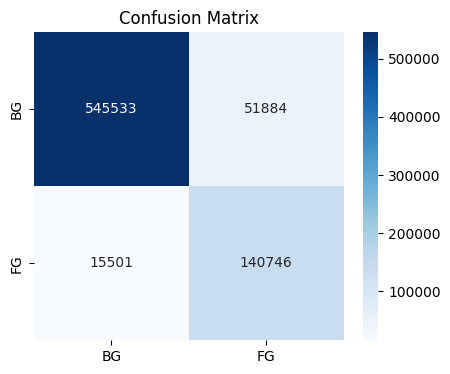

Average IoU over test set: 0.7075
Median IoU: 0.8569


In [92]:
# Cell 9: predictions + metrics
# Prepare X_test preprocessed as numpy to keep consistent ordering (batching order already deterministic)
X_test_prep = preprocess_fn((X_test.astype(np.float32)) * 255.0)

# Predict
y_pred = model.predict(X_test_prep, batch_size=batch_size)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)

# Flatten for global metrics
y_true_flat = Y_test.flatten().astype(np.uint8)
y_pred_flat = y_pred_bin.flatten().astype(np.uint8)

print("\nClassification Report:")
print(classification_report(y_true_flat, y_pred_flat, digits=4))

cm = confusion_matrix(y_true_flat, y_pred_flat)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["BG","FG"], yticklabels=["BG","FG"])
plt.title("Confusion Matrix")
plt.show()

# IoU per image
def compute_iou(y_t, y_p):
    y_t = y_t.astype(bool)
    y_p = y_p.astype(bool)
    inter = np.logical_and(y_t, y_p).sum()
    union = np.logical_or(y_t, y_p).sum()
    if union == 0:
        return 1.0
    return inter / union

ious = []
for i in range(len(X_test)):
    iou = compute_iou(Y_test[i].squeeze(), y_pred_bin[i].squeeze())
    ious.append(iou)

print(f"Average IoU over test set: {np.mean(ious):.4f}")
print(f"Median IoU: {np.median(ious):.4f}")


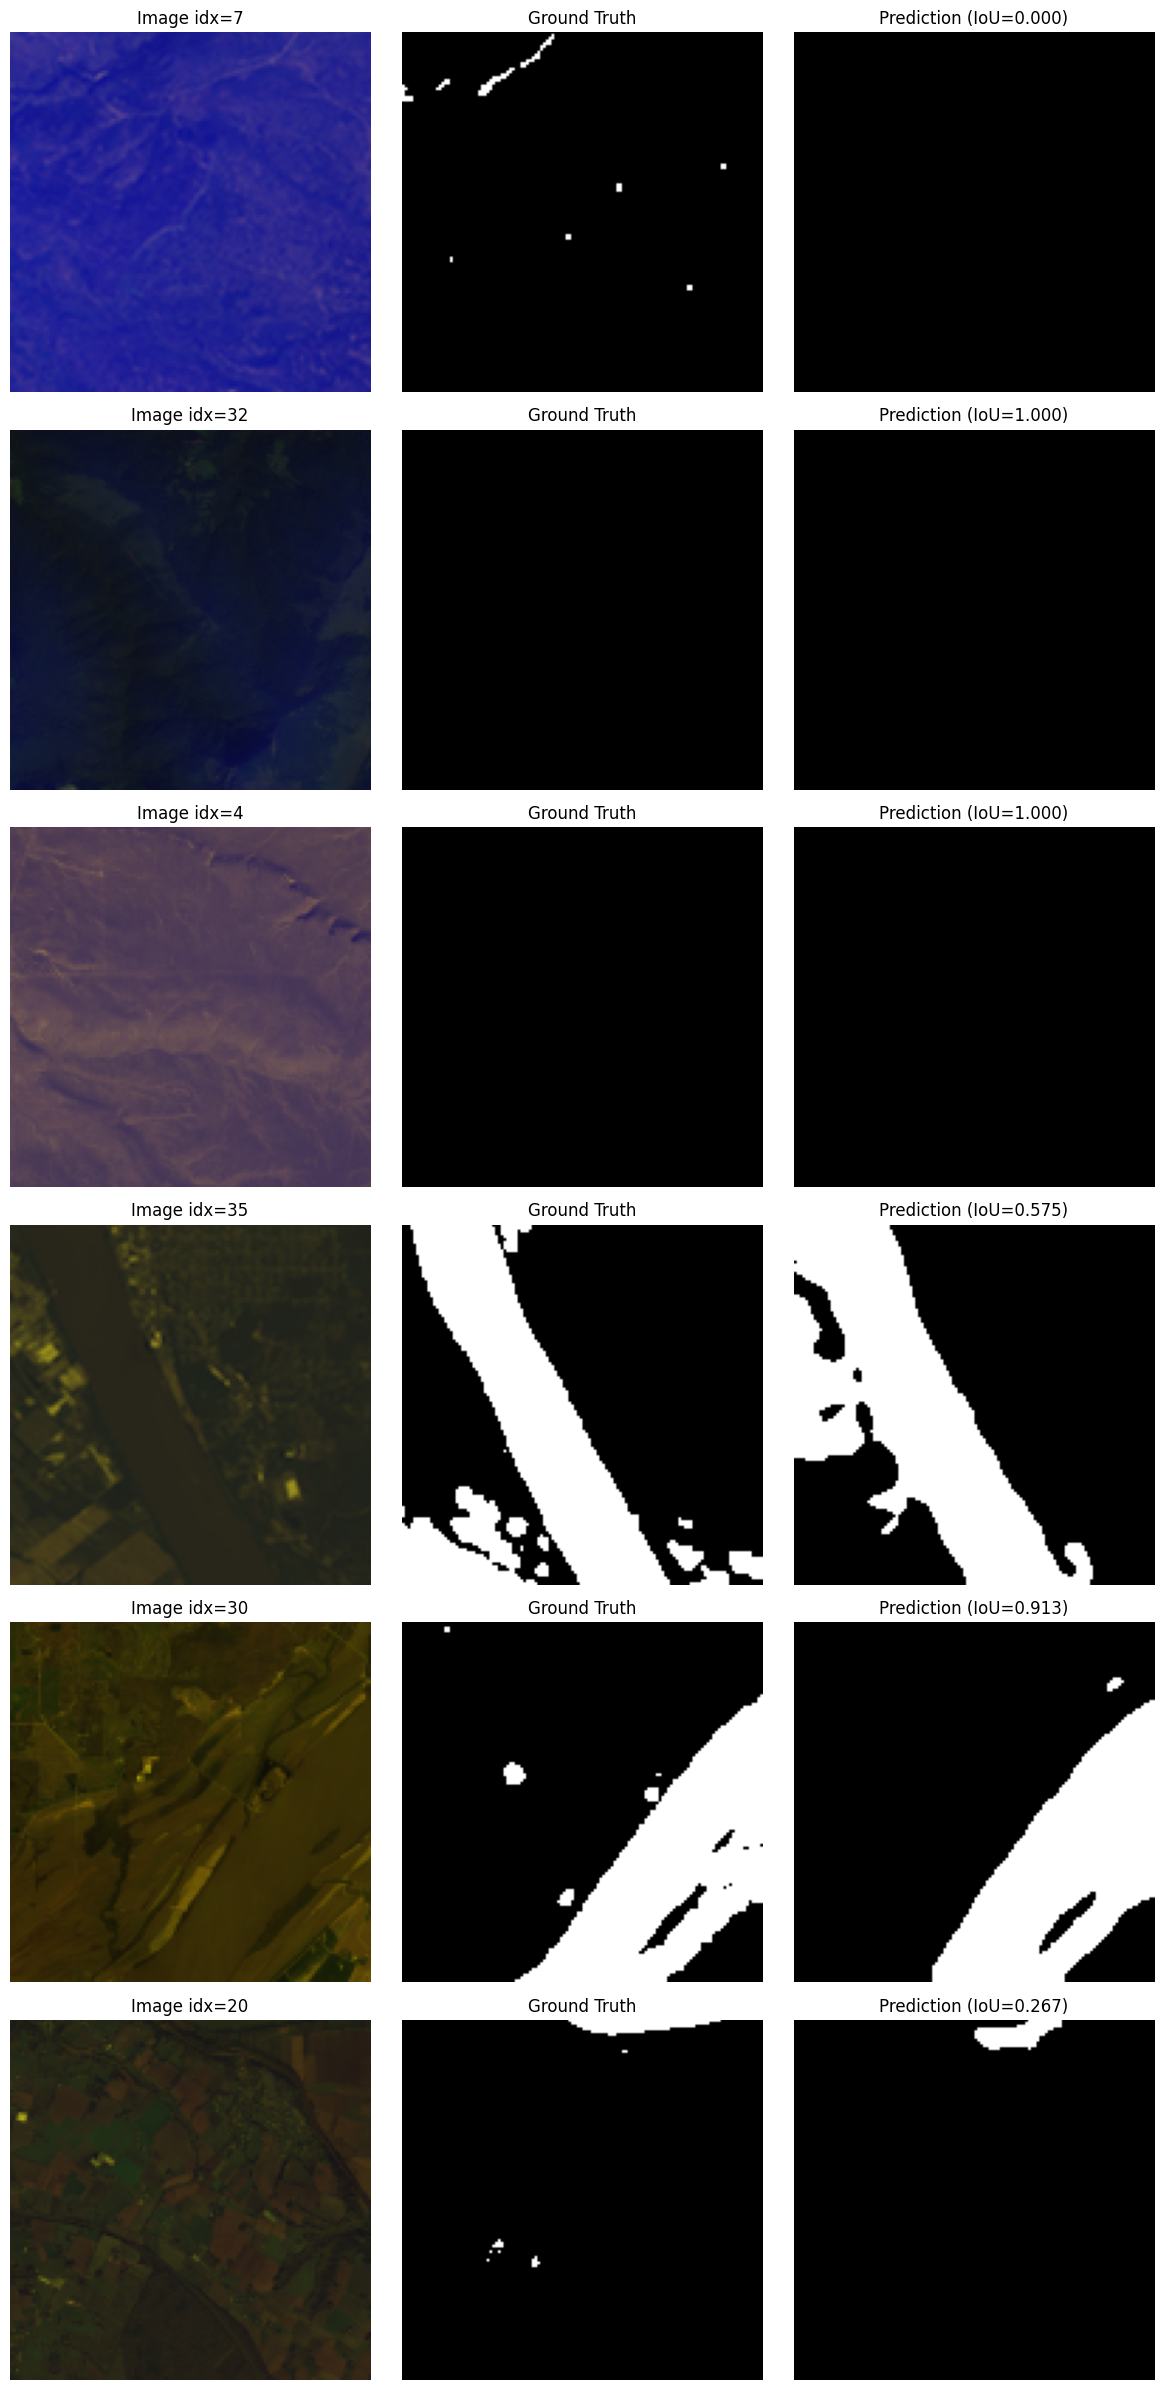

In [93]:
# Cell 10: visualize predictions (N examples)
def visualize_predictions(X_orig, Y_true, Y_pred_bin, indices=None, n=5, save_folder=None):
    if indices is None:
        # pick best + worst + random examples
        sorted_idx = np.argsort(ious)
        picks = []
        # worst
        picks.append(sorted_idx[0])
        # best
        picks.append(sorted_idx[-1])
        # add randoms
        rng = np.random.default_rng(42)
        while len(picks) < n:
            p = int(rng.integers(0, len(X_orig)))
            if p not in picks:
                picks.append(p)
        indices = picks[:n]
    else:
        indices = indices[:n]

    plt.figure(figsize=(12, 4 * n))
    for i, idx in enumerate(indices):
        iou = compute_iou(Y_true[idx].squeeze(), Y_pred_bin[idx].squeeze())

        # original (we show X_orig as-is — this is with original scale 0..1)
        plt.subplot(n, 3, 3*i + 1)
        plt.imshow(X_orig[idx])
        plt.title(f"Image idx={idx}")
        plt.axis("off")

        plt.subplot(n, 3, 3*i + 2)
        plt.imshow(Y_true[idx].squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(n, 3, 3*i + 3)
        plt.imshow(Y_pred_bin[idx].squeeze(), cmap="gray")
        plt.title(f"Prediction (IoU={iou:.3f})")
        plt.axis("off")

        # optional: save mask
        if save_folder:
            os.makedirs(save_folder, exist_ok=True)
            plt.imsave(os.path.join(save_folder, f"pred_{idx}.png"), (Y_pred_bin[idx].squeeze()*255).astype(np.uint8), cmap="gray")

    plt.tight_layout()
    plt.show()

# show 6 examples (best, worst + 4 random)
visualize_predictions(X_test, Y_test, y_pred_bin, n=6, save_folder=None)
